In [130]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astroquery.xmatch import XMatch
from astroquery.gaia import Gaia
from astropy.table import Table, join,vstack
import healpy as hp
from astropy.io import fits
from collections import defaultdict

In [131]:
import dustmaps.edenhofer2023
from dustmaps.edenhofer2023 import Edenhofer2023Query
edenhofer = Edenhofer2023Query(load_samples=False, integrated=True)

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


In [6]:
# Try reproduce l, b = 264.7◦,1.4◦, mu = 8-11
lon = 264.7
lat = 1.4
dist_exp = np.arange(400, 1400, 10)
factor = 2.8

# A_400 = np.sum((factor)*edenhofer(SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=d0*u.pc,frame='galactic')) for d0 in range(69, 400, 1))
A_exp = [0]*len(dist_exp)
for d in range(len(A_exp)):
    A_exp[d] = factor*edenhofer(SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=dist_exp[d]*u.pc,frame='galactic'))
# A_exp[0] = A_400+ (factor)*edenhofer(SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=400*u.pc,frame='galactic'))
# for d in range(1, len(dist_exp)):
#     A_exp[d] = A_exp[d-1]+ (factor)*edenhofer(SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=dist_exp[d]*u.pc,frame='galactic'))
#     # A_exp[d] = (factor)*edenhofer(SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=dist_exp[d]*u.pc,frame='galactic'))
    

In [9]:
SkyCoord(l = lon*u.deg, b = lat*u.deg, distance=dist_exp[d]*u.pc,frame='galactic').icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (134.40672218, -43.45203698, 1390.)>

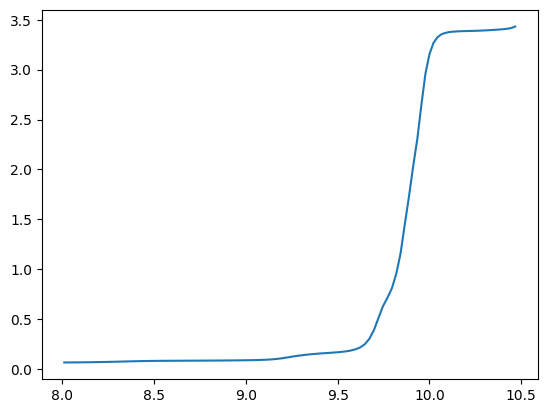

In [7]:
plt.plot(5*np.log10(dist_exp)-5, A_exp) #5*np.log10(359)-5

In [63]:
ra = np.arange(121.7, 122.38+0.05, 0.1)
dec = np.arange(-35.83, -35.6, 0.1)
distance = np.arange(69, 425, 1)
A_region = [[0]*len(ra) for _ in range(len(dec))]
region_res = defaultdict(list)
for i, a in enumerate(ra):
    for j, b in enumerate(dec):
        for k, c in enumerate(distance):
            A_region[j][i]+=(2*826.67)*edenhofer(SkyCoord(ra = a *u.deg, dec = b*u.deg, distance= c*u.pc))
            if c>316: #distance modulus 7.5; store in dictionary (ra, dec, distance)
                region_res[(a, b)].append(A_region[j][i])
                # print(f'Extinction value for distance {c}pc and distance modulus {5*np.log10(c)-5}:', A_region[j][i])

5.10090083564255
5.235446848729824
5.377415582914633
5.023537206923146
5.162430727374855
5.308959136283846
4.957870280959417
5.095314702908957
5.247122248206001
4.89506144692922
5.032487554750677
5.177462075951674
4.834397039915156
4.9598655333841375
5.082397062650047
4.760555615788091
4.867289192481197
4.992334398296352
4.6879818058640215
4.7809885011436695
4.9176621469208435
4.611793679088517
4.699906984996239
4.836711720831109


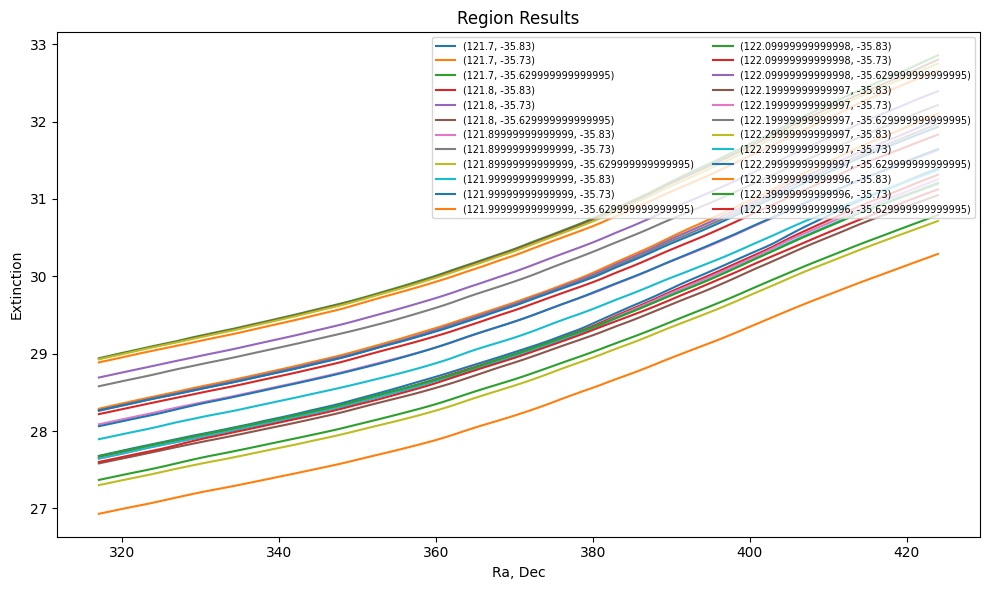

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
dist = np.arange(317,425)
for key, values in region_res.items():
    plt.plot(dist, values, label=str(key))  #
    print(np.abs(values[-1]-values[0])*2.8/2.04)
plt.xlabel('Ra, Dec')
plt.ylabel('Extinction')
plt.title('Region Results')
plt.legend(fontsize='x-small', loc='upper right', ncol=2)  # adjust for visibility
plt.tight_layout()
plt.show()

### Cone query 0.2 deg VelaC

In [132]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astroquery.xmatch import XMatch
from astroquery.gaia import Gaia
from astropy.table import Table, join,vstack
import healpy as hp
from astropy.io import fits

In [5]:
from dl import queryClient as qc
# Try reproduce l, b = 264.7◦,1.4◦
l_center = 264.7
b_center = 1.4
ra_center = SkyCoord(l = l_center*u.deg, b = b_center*u.deg,frame='galactic').icrs.ra.value
dec_center = SkyCoord(l = l_center*u.deg, b = b_center*u.deg,frame='galactic').icrs.dec.value
radius_query = 0.2
region_name = "VelaC_exp" 

In [46]:
query1 = f"""
        SELECT *
        FROM decaps_dr2.object
        WHERE q3c_radial_query(ra, dec, {ra_center}, {dec_center}, {radius_query}) """

query3 = f"""SELECT * 
            FROM twomass.psc
            WHERE q3c_radial_query(ra, dec, {ra_center}, {dec_center}, {radius_query})"""


In [47]:
df1 = qc.query(sql=query1,fmt='table') 
df3 = qc.query(sql=query3,fmt='table')

In [ ]:
twomass_xmatched = XMatch.query(cat1 = df1, cat2 = 'vizier:II/246/out', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
twomass_xmatch_pd = twomass_xmatched.to_pandas()
twomass_xmatch_id = twomass_xmatch_pd.iloc[:, 210:211]
twomass_xmatch_id['obj_id'] = twomass_xmatch_pd['obj_id'].values
twomass_xmatch_id['angDist'] = twomass_xmatch_pd['angDist'].values
df1_pd = df1.to_pandas()
merge1 = df1_pd.merge(twomass_xmatch_id, how='left', left_on='obj_id', right_on='obj_id')
merge2 = merge1.merge(df3.to_pandas().iloc[:, 2:], how='left',left_on='2MASS', right_on = 'designation') # Table.from_pandas(merge2).write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_crossmatched.csv",format='csv', overwrite=True)
# Table.from_pandas(merge2).write(f"/Users/anniegao/Documents/CG_mapping_files/VelaC/{region_name}_Decaps2TwoMASS_crossmatched.csv",format='csv', overwrite=True)

In [92]:
## Cross Match with Gaia
gaia_xmatched = XMatch.query(cat1 = df1, cat2='vizier:I/355/gaiadr3', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
xmatch_pd = gaia_xmatched.to_pandas()
xmatch_pd_tomerge = xmatch_pd.iloc[:, 210:]
xmatch_pd_tomerge['obj_id'] = xmatch_pd['obj_id'].values
xmatch_pd_tomerge['angDist'] = xmatch_pd['angDist'].values
merge_xmatch = df1_pd.merge(xmatch_pd_tomerge, how='left', left_on='obj_id', right_on='obj_id')
merged_pd = merge_xmatch.drop_duplicates(subset='obj_id', keep='first') # because there are 13 stars that are duplicated -- two Gaia sources are within 0.5 arcsec from Decaps2. Only keep the closer one. 
# merged_table = Table.from_pandas(merged_pd) # convert back to astropy table # merged_table.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2Gaia_crossmatched.csv",format='csv')
print('Finished crossmatching with Gaia')

Finished crossmatching with Gaia


In [27]:
a = merge2.iloc[:, 209:]
a['obj_id'] = merge2['obj_id']
decaps_2mass_gaia = merged_table.to_pandas().merge(a, on = 'obj_id') # merge Decaps + 2MASS with Decaps + Gaia 
print('Finished crossmatching Decaps2, Gaia, 2MASS; and saved.')
merged_table_path =f"/Users/anniegao/Documents/CG_mapping_files/VelaC/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv"
Table.from_pandas(decaps_2mass_gaia).write(merged_table_path,format='csv', overwrite=True)

Finished crossmatching Decaps2, Gaia, 2MASS; and saved.


### Brutus for stellar modeling

- flux should be small values. should be not close to 1. 
- mask need to match both mag and flux array. Good data should have mask=True, bad data (e.g. mag=inf) have mask=False. 

In [100]:
import os
import brutus
import h5py
import sys
import glob
from brutus import filters
from brutus import seds
from brutus import utils
from brutus.utils import inv_magnitude
from brutus import fitting
from brutus import pdf
from scipy import stats
from numpy import unravel_index
import signal
import time
from zero_point import zpt
import shutil

In [ ]:
merged_table_path =f"/Users/anniegao/Documents/CG_mapping_files/VelaC/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv"
merged_table = Table.read(merged_table_path,format='csv')
## post-process the data -- quality cut
band_check = np.c_[(merged_table['nmag_cflux_ok_g']>0) & (merged_table['mean_mag_g']< np.inf) & (merged_table['fracflux_avg_g']>0.75),
                   (merged_table['nmag_cflux_ok_r']>0) & (merged_table['mean_mag_r']< np.inf) & (merged_table['fracflux_avg_r']>0.75),
                   (merged_table['nmag_cflux_ok_i']>0) & (merged_table['mean_mag_i']< np.inf) & (merged_table['fracflux_avg_i']>0.75),
                   (merged_table['nmag_cflux_ok_z']>0) & (merged_table['mean_mag_z']< np.inf) & (merged_table['fracflux_avg_z']>0.75), 
                   (merged_table['nmag_cflux_ok_y']>0) & (merged_table['mean_mag_y']< np.inf) & (merged_table['fracflux_avg_y']>0.75), 
                   (merged_table['j_m']>0) & (merged_table['cc_flg'] =='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['h_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['k_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0)
                   ]
band_mask = np.sum(band_check, axis=1)>=4
merged_table_selected = merged_table[band_mask]
flux_decam = np.c_[merged_table_selected['mean_g'].value, merged_table_selected['mean_r'].value, merged_table_selected['mean_i'].value, merged_table_selected['mean_z'].value, merged_table_selected['mean_y'].value]
mag_2mass =  np.c_[merged_table_selected['j_m'].value, merged_table_selected['h_m'].value, merged_table_selected['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
flux_decam_err = np.c_[merged_table_selected['err_g'].value, merged_table_selected['err_r'].value, merged_table_selected['err_i'].value,merged_table_selected['err_z'].value, merged_table_selected['err_y'].value]
magerr_2mass = np.c_[merged_table_selected['j_msigcom'].value, merged_table_selected['h_msigcom'].value, merged_table_selected['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
#mag, mag_err = utils.magnitude(flux, flux_err)
mag_decam = -2.5*np.log10(flux_decam)
magerr_decam = 1.086*flux_decam_err/flux_decam
mag = np.c_[mag_decam[:], mag_2mass[:]]
mag_err = np.c_[magerr_decam[:], magerr_2mass[:]]

#add 0.02 mag uncertainty in quadrature to decaps
mag_err[:,0:5] = np.sqrt(mag_err[:,0:5]**2 + 0.02**2)
#add 0.03 mag uncertainty in quadrature to vvv/2mass
mag_err[:,5:] = np.sqrt(mag_err[:,5:]**2 + 0.03**2)

# mag=0 means that there is no detection
mag = np.where(np.isclose(mag, 0.), np.nan, mag)
mag_err = np.where(np.isclose(mag, 0.), np.nan, mag_err)

# convert back to flux
flux, flux_err = inv_magnitude(mag, mag_err)

In [373]:
flux_not_close0 = ~np.isclose(flux, 0.)
flux_mask = np.sum(flux_not_close0, axis=1)>=4
flux_new = flux[flux_mask, :]
flux_err_new = flux_err[flux_mask, :]
mask = np.isfinite(mag_err)[flux_mask, :]  # create boolean band mask
parallax, parallax_err = merged_table_selected['Plx'][flux_mask], merged_table_selected['e_Plx'][flux_mask]
correct_parallax_mask = (np.isfinite(parallax)) & (np.isin(merged_table_selected['Solved'][flux_mask], [31, 95]))
from zero_point import zpt
#apply parallax correction
parallax_correction = zpt.get_zpt(merged_table_selected['Gmag'][flux_mask][correct_parallax_mask], 
                                  merged_table_selected['nueff'][flux_mask][correct_parallax_mask], 
                                  merged_table_selected['pscol'][flux_mask][correct_parallax_mask], 
                                  merged_table_selected['elat'][flux_mask][correct_parallax_mask], 
                                  merged_table_selected['Solved'][flux_mask][correct_parallax_mask],
                                  _warnings=False)
parallax_correction[~np.isfinite(parallax_correction)] = 0 
parallax[correct_parallax_mask] = parallax[correct_parallax_mask]-parallax_correction

# psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
# parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = SkyCoord(ra = merged_table_selected['ra'].value*u.deg, dec = merged_table_selected['dec'].value*u.deg ).transform_to('galactic')
coords = coords[flux_mask]

## Fit data 
Ndraws = 100 #draws to save to generate the 2D posterior
thin = 20 # factor to thin samples by for saving to disk
filt = filters.decam[1:] + filters.tmass[:] #+filters.gaia[:]
# zero points
zp_mist = brutus.utils.load_offsets('/Users/anniegao/Documents/CG_mapping_files/star_modeling/offsets_mist_v9.txt',filters=filt)
# import MIST model grid
gridfile = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/grid_mist_v10.h5'
(models_mist, labels_mist, lmask_mist) = brutus.utils.load_models(gridfile, filters=filt, include_binaries=False)
BF_mist = fitting.BruteForce(models_mist, labels_mist, lmask_mist)
#load tables for parallax zeropoint correction
zpt.load_tables()

DECam_g (0.0%)
DECam_r (-4.0%)
DECam_i (-5.0%)
DECam_z (-4.0%)
DECam_Y (-5.0%)
2MASS_J (-2.0%)
2MASS_H (4.0%)
2MASS_Ks (3.0%)
Reading filter 2MASS_Ks           


In [405]:
dustfile = '/Users/anniegao/Dropbox/Gum_Nebula/data/gum_dust_map.fits'  # 3-D dust map
filename = '/Users/anniegao/Documents/CG_mapping_files/VelaC/'
region_data = f'{region_name}_mist_from_decapsTwomassGaia'
BF_mist.fit(flux_new, flux_err_new, mask, 
            merged_table_selected['SolID'], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value], 
            parallax=parallax, 
            parallax_err=parallax_err,
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )

Fitting object 5308/5308 [chi2/n: 3.5/9] (mean time: 1.202 s/obj, est. time remaining:      0.000 s)    


In [406]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx'][:]   #np.vstack((f['model_idx'][:], f2['model_idx'][:])) #model indices
chi2_mist =f['obj_chi2min'][:] #best fit chi2
nbands_mist = f['obj_Nbands'][:] # number of bands in fit
dists_mist = f['samps_dist'][:] # distance samples
reds_mist = f['samps_red'][:] # A(V) samples
dreds_mist = f['samps_dred'][:] # R(V) samples
lnps_mist = f['samps_logp'][:] # log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)

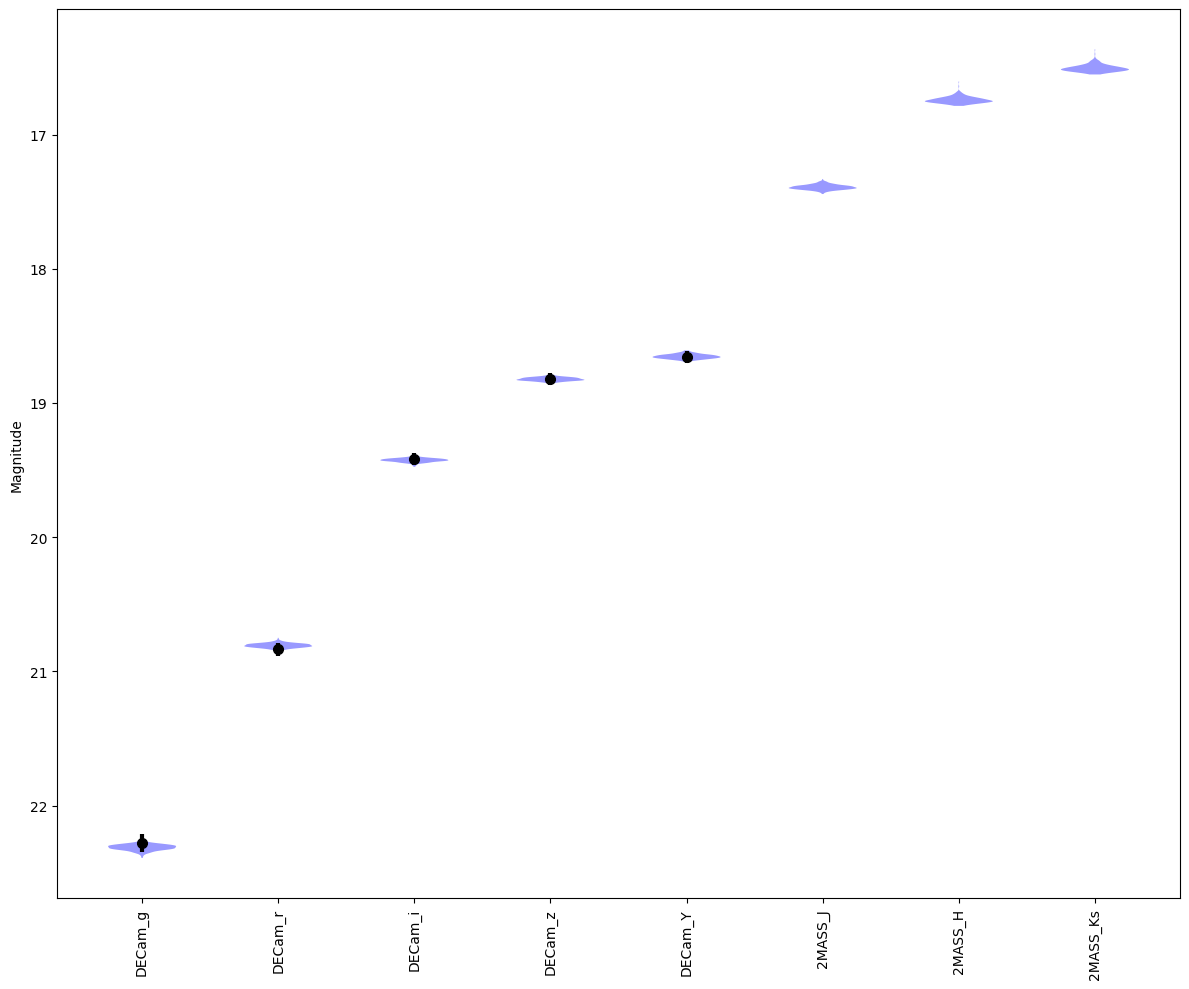

In [407]:
# pick an object
i = 4
from brutus import plotting as bplot
# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_mist,  # stellar model grid
                                            idxs_mist[i],  # model indices
                                            reds_mist[i],  # A(V) draws
                                            dreds_mist[i],  # R(V) draws
                                            dists_mist[i],  # distance draws
                                            data=flux_new[i], data_err=flux_err_new[i],  # data
                                            # flux = True,
                                            data_mask=mask[i],  # band mask
                                            offset=zp_mist,  # photometric offsets
                                            psig=2.,  # plot 2-sigma errors
                                            labels=filt,  # filters 
                                            vcolor='blue',  # "violin plot" colors for the posteriors
                                            pcolor='black')  # photometry colors for the data

4799


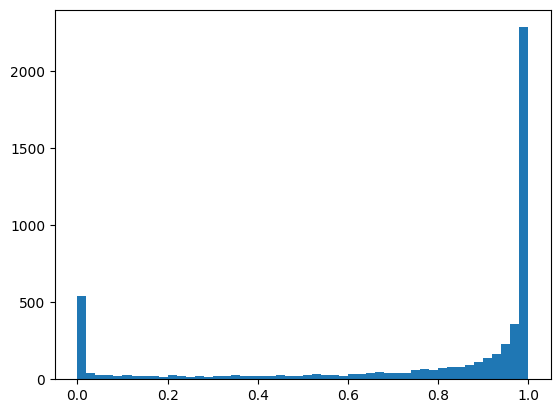

In [408]:
print(sum(good))
plt.hist(pval, bins=50)
plt.show()

In [409]:
import warnings
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]

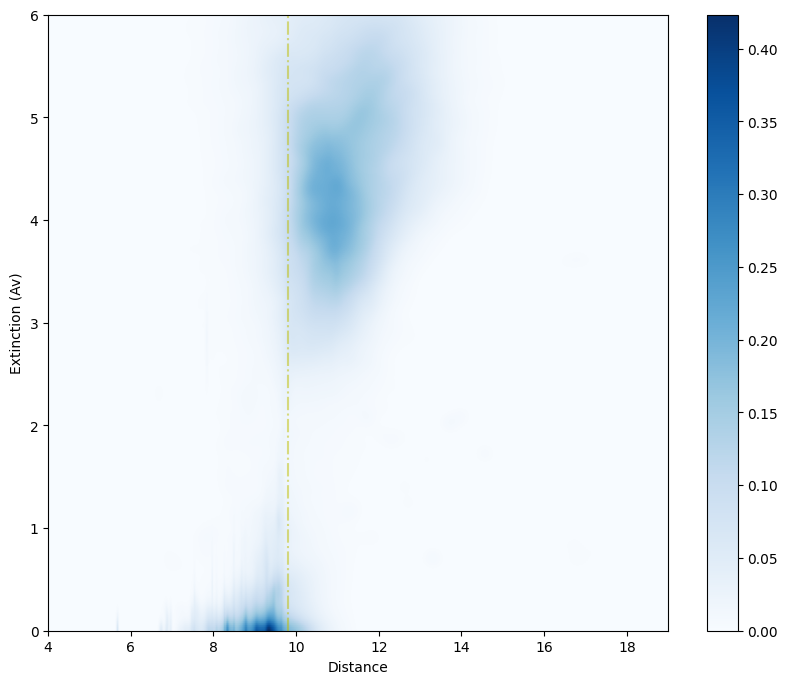

In [420]:
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance')
ax.set_ylabel('Extinction (Av)')


plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            # vmin=0, vmax=0.005
            )
plt.axvline(9.8, c='y', alpha=0.5, ls='-.')
# plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()